In [1]:
import pickle
from pathlib import Path
from types import SimpleNamespace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import sklearn.cross_decomposition
import sklearn.linear_model
import statsmodels
import statsmodels.api
import warnings

In [2]:
import sys
sys.path.append("/Users/missd/Desktop/6. Semester/6. Model Deployment Maintenance/MDM - Python Projekt/src/")
import mdm_python.data.db_entsoe as db_entsoe

In [3]:
model_directory = Path("../data/models").resolve()

In [4]:
energy_data = db_entsoe.extract_daily_energy()

## Prepare Data

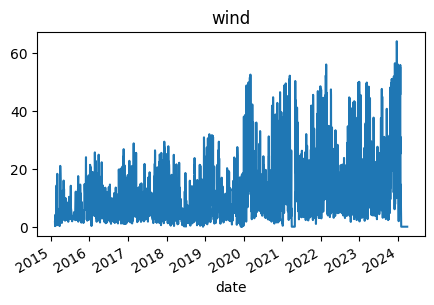

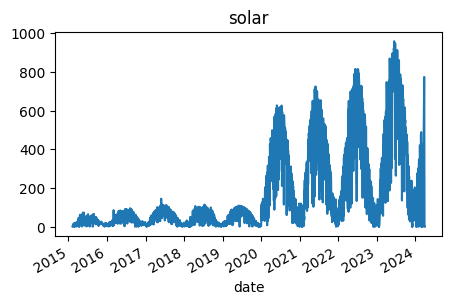

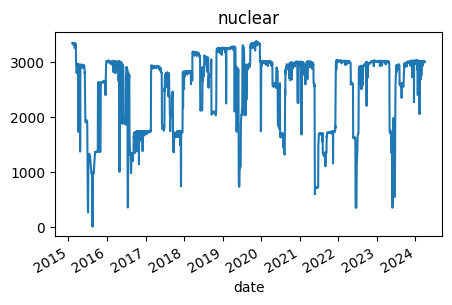

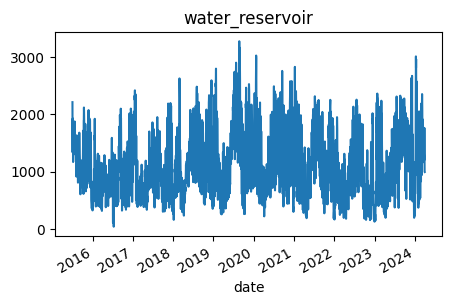

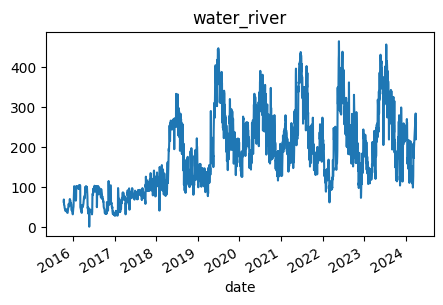

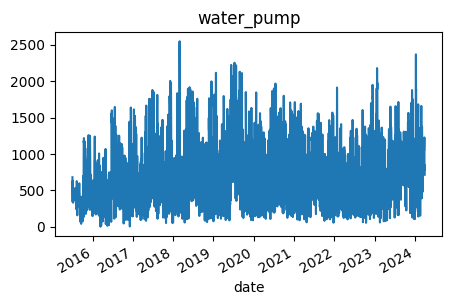

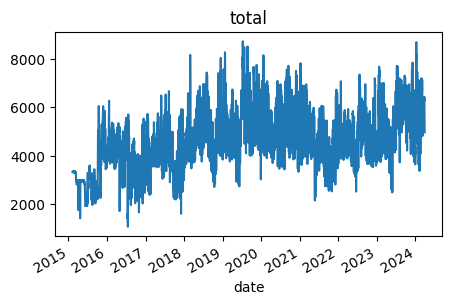

In [7]:
plot_data_simple(energy_data)

In [6]:
def show_missing_data(data):
    print(pd.date_range(start=data.index[0], end=data.index[-1]).difference(data.index))
    print(data.isnull().sum())

In [5]:
def plot_data_simple(data: pd.DataFrame):
    for col_name, value in data.items():
        plt.figure(figsize=(5, 3))
        plt.title(col_name)
        value.plot()
        plt.show()

In [8]:
def prepare_raw_data (data: pd.DataFrame) -> dict:
    """
    Transform the data to log-scale with an offset to handle the high number of zeros
    The offset will change the skew-of the histogram close to 0
    """
    data = data.drop(columns="total")
    
    offset = dict(
        wind = 1.4,
        solar = 6,
        water_reservoir = 900,
        water_river = 150,
        water_pump = 700
    )
    data_transformed = data.apply(lambda col: np.log10(col+offset[col.name]) if col.name in offset else col)
    
    """
    Create new DataFrame with the missing days in the index and NaN-Values
    Fill NaN-Values with the average between the previous and the next value
    """
    index_date = pd.date_range(start=data_transformed.index[0], end=data_transformed.index[-1], freq='D')
    data_fixed = data_transformed.reindex(index_date)
    data_fixed = data_fixed.interpolate(method='linear')
    data_fixed = data_fixed.dropna()
    assert data_fixed.index.freq is not None, "Data must still be fixed-frequency"

    dict_of_transformed_data = dict()

    for col_name in data_fixed.columns:
        values = SimpleNamespace(
            name = col_name,
            transformed_values = data_fixed[col_name],
            offset = offset.get(col_name),
        )
        dict_of_transformed_data[col_name] = values
    
    return dict_of_transformed_data

In [9]:
def detrend_and_deseasonalize_data(prepared_data: dict) -> dict:
    """
    Detrend and deseasonlize the prepared data.
    Create a dictionnary with Name, detrended values and the baseline
    """
    warnings.filterwarnings("ignore", message="Series.fillna with 'method' is deprecated.*")

    breakpoints = dict(
        solar = pd.Timestamp("2020-01-01",tz=prepared_data["solar"].transformed_values.index.tz), # breakpoints for structural break
    )
    
    for col_name, values in prepared_data.items():
        modelling_basis = values.transformed_values
        if breakpoints.get(col_name) is not None:
            modelling_basis = modelling_basis[modelling_basis.index >= breakpoints.get(col_name)]      
        weekly_seasonality = statsmodels.api.tsa.seasonal_decompose(modelling_basis, period=7, model="additive", extrapolate_trend='freq')
        week_removed = modelling_basis - weekly_seasonality.seasonal
        yearly_seasonality = statsmodels.api.tsa.seasonal_decompose(week_removed, period=365, model="additive", extrapolate_trend='freq')
        trend = yearly_seasonality.trend
        baseline = yearly_seasonality.seasonal + trend + weekly_seasonality.seasonal
        
        changed_data_deseasonalized = modelling_basis - baseline
        
        values.detrended_values = changed_data_deseasonalized
        values.baseline = baseline
    
    return prepared_data

In [10]:
data = prepare_raw_data(energy_data)
data = detrend_and_deseasonalize_data(data)

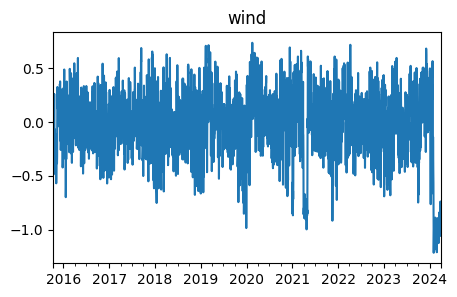

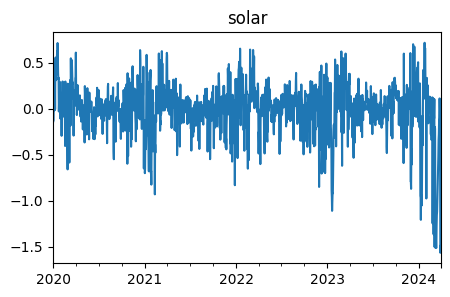

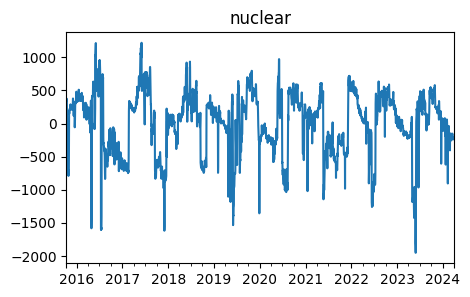

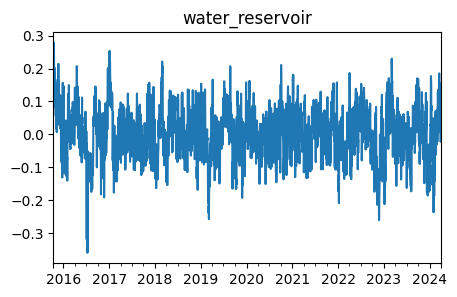

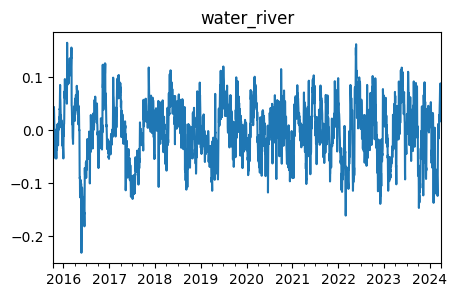

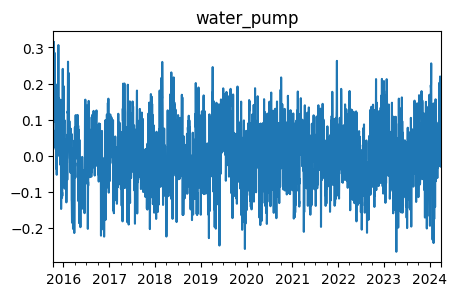

In [28]:
for k, v in data.items():
    name= data[k].name
    value = data[k].detrended_values
    plt.figure(figsize=(5, 3))
    plt.title(name)
    value.plot()

## Check Data for Stationarity and White Noise

In [25]:
def check_for_stationarity(name:str, data:pd.Series) -> bool:
    """
    Compute ADF-Value: If the value is very low (negative), it indicates, the data is Stationary
    Compute P-Value: If the value is between -0.05 and 0.05, it indicates, the data is Stationary
    """
    dftest = statsmodels.api.tsa.stattools.adfuller(data, autolag="AIC")
    
    if (dftest[0]<-2.8) and (abs(dftest[1])>-0.05):
        #print(f'{name}-data is most likely Stationary\n')
        return True

    print(f'\nStationary-Test for {name}:')
    print("ADF:", dftest[0])
    print("P-Value:", dftest[1])
    
    print(f'{name}-data is most likely not Stationary!\n')
    return False

In [26]:
def check_if_white_noise(name:str, data:pd.Series) -> bool:
    """
    Create a TimeSeries-Plot: If the mean is different from 0, it indicates, the data is NOT White Noise
    Compute ACF and PACF: If at least one of them has some significant lags, it indicates, the data is NOT White Noise
    Compute Ljung-Box-Test: If the value is between -0.05 and 0.05, it indicates, the data is NOT White Noise
    """
    mean = data.mean()
    acf = statsmodels.tsa.stattools.acf(data, nlags=40)
    pacf = statsmodels.tsa.stattools.pacf(data, nlags=40)
    significant_acf_lags = len([lag for lag, acf_value in enumerate(acf) if abs(acf_value) > 0.2])-1
    significant_pacf_lags = len([lag for lag, pacf_value in enumerate(pacf) if abs(pacf_value) > 0.2])-1
    
    # Ljung-Box Test
    lb_test = statsmodels.api.stats.acorr_ljungbox(data, lags=[10], return_df=True)

    if (significant_acf_lags>1 or significant_pacf_lags>1) and (abs(lb_test['lb_pvalue'].iloc[0])<0.05) and (mean!=0):
        #print(f'{name}-data is most likely not White Noise!\n')
        return True

    print(f'White-Noise-Test for {name}:')
    print(f'Ljung-Box-Test (p-value): {lb_test["lb_pvalue"].iloc[0]}')
    print(f'Mean: {mean}')
    print(f'Significant ACF-Lags: {significant_acf_lags}')
    print(f'Significant PACF-Lags: {significant_pacf_lags}')
    
    print(f'{name}-data is most likely White Noise!\n')
    return False

## Modelling Data

In [27]:
def get_acf_and_pacf_lags(name:str, data:pd.Series, plot_acf_pacf=False) ->tuple:
    """
    Compute the significant ACF- and PACF-Lags as a base for the modelling process
    If plot_acf_pacf is True, the ACF- and PACF-Lags are plotted
    """
    acf_data = statsmodels.tsa.stattools.acf(data, nlags=40)
    pacf_data= statsmodels.tsa.stattools.pacf(data, nlags=40)

    if plot_acf_pacf:
        # Create ACF plot
        plt.figure(figsize=(12, 6))
        statsmodels.graphics.tsaplots.plot_acf(data, lags=40, alpha=1)  # Plot ACF using statsmodels
        plt.fill_between(range(len(acf_data)), -0.2, 0.2, color='red', alpha=0.2)  # Add shaded region for significance level
        plt.title(f'Autocorrelation Function (ACF) of {name}')
        plt.xlabel('Lag')
        plt.ylabel('ACF')
        plt.show()
        
        # Create PACF plot
        plt.figure(figsize=(12, 6))
        statsmodels.graphics.tsaplots.plot_pacf(data, lags=40, alpha=1)  # Plot PACF using statsmodels
        plt.fill_between(range(len(pacf_data)), -0.2, 0.2, color='red', alpha=0.2)  # Add shaded region for significance level
        plt.title(f'Partial Autocorrelation Function (PACF) of {name}')
        plt.xlabel('Lag')
        plt.ylabel('PACF')
        plt.show()

    significant_acf_lags = len([lag for lag, acf_value in enumerate(acf_data) if abs(acf_value) > 0.2])-1
    significant_pacf_lags = len([lag for lag, pacf_value in enumerate(pacf_data) if abs(pacf_value) > 0.2])-1
    
    return significant_acf_lags, significant_pacf_lags

In [28]:
def create_train_and_test_data(detrended_data:pd.Series, test_size=0.2):
    """
    Create a non-random Training- and a Test-Dataset
    """
    train_data = detrended_data.iloc[:-int(len(detrended_data) * test_size)]
    test_data = detrended_data.iloc[-int(len(detrended_data) * test_size):]    
    return train_data, test_data

In [29]:
def ARIMA_model(data:pd.Series, p:int, d:int, q:int):
    """
    Model the data with an ARIMA-Model; if there is seasonality, a seasonal difference is calculated
    Some warnings are ignored, since many parameters are tested for the best model
    """
    warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
    warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
    warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")    

    model = statsmodels.tsa.arima.model.ARIMA(data, order=(p, d, q), freq='D')
    fit_result = model.fit()
    return fit_result

In [30]:
def check_significance_of_coefficients(fitted_model, significance_level=0.5) -> bool:
    """
    Check, if the computed coefficients are significant
    """
    p_values = fitted_model.pvalues
    for i, p_value in enumerate(p_values):
        if not (abs(p_value) < significance_level):
            return False
        return True

In [31]:
def check_accuracy(fitted_model, test_data):
    """
    Check, how accurate the fitted Model used on the test-dataset,
    by computing the MeanSquaredError and the RootMeanSquaredError
    """
    y_true = test_data
    y_pred = fitted_model.forecast(steps=len(test_data))
    mse =  sklearn.metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, rmse

In [32]:
def find_best_model(name, train_data, test_data, acf_lag, pacf_lag) -> dict:
    """
    Try different Meta-Parameters to check, if the AIC and MSE are becoming better
    Return the best model
    """
    best_model = None

    lowest_aic = 1000000
    lowest_mse = 1000000

    acf_lag = acf_lag if acf_lag<5 else 5
    pacf_lag = pacf_lag if pacf_lag<5 else 5
    
    for p in range(acf_lag-1 if acf_lag>1 else 0, acf_lag+1):
        for q in range(pacf_lag-2 if pacf_lag>2 else 0, pacf_lag+2):
           for d in range(2):
                print(f'ARIMA for {name}: ({p}, {d}, {q})')
                fit_result = ARIMA_model(train_data, p, d, q)
                if not check_significance_of_coefficients(fit_result):
                    continue
                mse, rmse = check_accuracy(fit_result, test_data)
                if fit_result.aic<lowest_aic and mse<lowest_mse:
                    lowest_aic=fit_result.aic
                    lowest_mse=mse
                    best_model = dict(
                        name=name,
                        p=p,
                        d=d,
                        q=q,
                        model=fit_result.model,
                        mse=mse,
                        rmse=rmse,
                        aic=fit_result.aic,
                    )
    assert best_model is not None
    return best_model

In [33]:
def store_model(data_set:dict):
    model_directory.mkdir(parents=True, exist_ok=True)
    for name, data in data_set.items():
        with open(model_directory/f"{name}.pickle", "wb") as fh:
            pickle.dump(data.model, fh)

In [34]:
def run_modelling_process(raw_data:pd.Series) -> dict:
    """
    Prepare the data
    Check for Stationarity and White Noise
    Run the process to find the best model
    Store the model as a Pickle-File
    """
    data_set = prepare_raw_data(raw_data)
    data_set = detrend_and_deseasonalize_data(data_set)

    for name, data in data_set.items():
        if check_for_stationarity(name, data.detrended_values) and check_if_white_noise(name, data.detrended_values):
            print(f'{name} is most likely stationary and not White Noise')
    
    for name, data in data_set.items():
        acf_lag, pacf_lag = get_acf_and_pacf_lags(name, data.detrended_values)
        train_data, test_data = create_train_and_test_data(data.detrended_values)
        best_model = find_best_model(name, train_data, test_data, acf_lag, pacf_lag)
        data.model = best_model

    store_model(data_set)
    
    return data_set

In [35]:
def manually_test_model(raw_data:pd.DataFrame, energy_type:str, p:int, q:int):
    """
    Check other parameters for a single energy_type manually
    """

    data_set = prepare_raw_data(raw_data)
    data_set = detrend_and_deseasonalize_data(data_set)
    data = data_set[energy_type]
        
    train_data, test_data = create_train_and_test_data(data.detrended_values)   
    model = find_best_model(energy_type, train_data, test_data, p, q)
    
    print(f'AIC: {model["aic"]}\nMSE: {model["mse"]}')
    return model

In [40]:
model_data = run_modelling_process(energy_data)

wind is most likely stationary and not White Noise
solar is most likely stationary and not White Noise
nuclear is most likely stationary and not White Noise
water_reservoir is most likely stationary and not White Noise
water_river is most likely stationary and not White Noise
water_pump is most likely stationary and not White Noise
ARIMA for wind: (4, 0, 0)
ARIMA for wind: (4, 1, 0)
ARIMA for wind: (4, 0, 1)
ARIMA for wind: (4, 1, 1)
ARIMA for wind: (4, 0, 2)
ARIMA for wind: (4, 1, 2)
ARIMA for wind: (5, 0, 0)
ARIMA for wind: (5, 1, 0)
ARIMA for wind: (5, 0, 1)
ARIMA for wind: (5, 1, 1)
ARIMA for wind: (5, 0, 2)
ARIMA for wind: (5, 1, 2)
ARIMA for solar: (3, 0, 0)
ARIMA for solar: (3, 1, 0)
ARIMA for solar: (3, 0, 1)
ARIMA for solar: (3, 1, 1)
ARIMA for solar: (3, 0, 2)
ARIMA for solar: (3, 1, 2)
ARIMA for solar: (4, 0, 0)
ARIMA for solar: (4, 1, 0)
ARIMA for solar: (4, 0, 1)
ARIMA for solar: (4, 1, 1)
ARIMA for solar: (4, 0, 2)
ARIMA for solar: (4, 1, 2)
ARIMA for nuclear: (4, 0, 0)
A

In [84]:
def forecasting(raw_data, forecast_horizon=50):



    



    



    
    weather_data_temp = weather_data.avg_temp
    weather_data_wind = weather_data.wind_speed
    weather_data_temp_deseasonalized = weather_data_temp.diff(12).dropna()

    forecasting_model_temp = ARIMA_model(weather_data_temp_deseasonalized, best_model_temp['p'], best_model_temp['d'], best_model_temp['q'])
    forecasting_model_wind = ARIMA_model(weather_data_wind, best_model_wind['p'], best_model_wind['d'], best_model_wind['q'])
    
    index_future = pd.date_range(start=weather_data.index[-1], periods=forecast_horizon + 1, freq='D')[1:]
    forecast_df = pd.DataFrame(index=index_future, columns=['avg_temp', 'wind_speed'])
    temp_forecast = forecasting_model_temp.get_forecast(steps=forecast_horizon)  # 95% confidence interval
    wind_forecast = forecasting_model_wind.get_forecast(steps=forecast_horizon)  # 95% confidence interval

    
    # Add back the seasonal component to the deseasonalized temperature forecast
    temp_mean = temp_forecast.summary_frame()['mean']
    wind_mean = wind_forecast.summary_frame()['mean']
    temp_lower = temp_forecast.summary_frame().mean_ci_lower
    temp_upper = temp_forecast.summary_frame().mean_ci_upper
    wind_lower = wind_forecast.summary_frame().mean_ci_lower
    wind_upper = wind_forecast.summary_frame().mean_ci_upper


    forecast_df['avg_temp'] = temp_mean.cumsum()  # re-seasonalized
    forecast_df['wind_speed'] = wind_mean
    forecast_df['Temperature_CI_Difference'] = temp_upper - temp_lower
    forecast_df['Temperature_Lower_CI'] = forecast_df['avg_temp'] - forecast_df['Temperature_CI_Difference']
    forecast_df['Temperature_Upper_CI'] = forecast_df['avg_temp'] + forecast_df['Temperature_CI_Difference']
    forecast_df['Wind_Lower_CI'] = wind_lower
    forecast_df['Wind_Upper_CI'] = wind_upper

    return forecast_df

In [85]:
def plot_forecasting(forecast_df, weather_data):

    # Plot the observed data
    plt.figure(figsize=(10, 6))
    plt.plot(weather_data.index, weather_data['avg_temp'], label='Observed Temperature', color='blue')
    plt.plot(weather_data.index, weather_data['wind_speed'], label='Observed Wind', color='green')
    
    # Plot the forecasted values
    plt.plot(forecast_df.index, forecast_df['avg_temp'], label='Forecasted Temperature', color='red')
    plt.plot(forecast_df.index, forecast_df['wind_speed'], label='Forecasted Wind', color='green')
    
    # Add shades for uncertainty intervals
    plt.fill_between(forecast_df.index, forecast_df['Temperature_Lower_CI'], forecast_df['Temperature_Upper_CI'], color='lightcoral', alpha=0.3)
    plt.fill_between(forecast_df.index, forecast_df['Wind_Lower_CI'], forecast_df['Wind_Upper_CI'], color='lightgreen', alpha=0.3)
    
    # Add labels, legend, and title
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Observed and Forecasted Data with Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

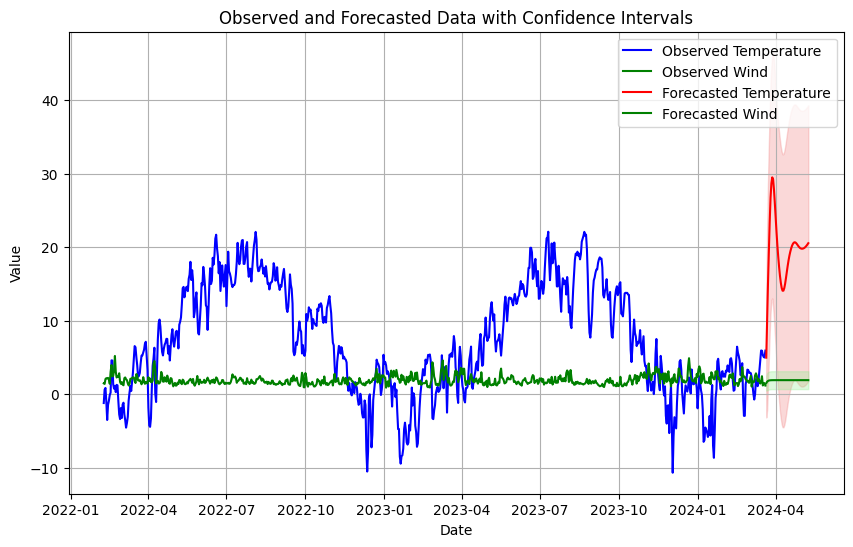

In [86]:
df = forecasting(weather_data, best_model_wind, best_model_temp)
plot_forecasting(df, weather_data)

_______________